In [ ]:
!pip install opendatasets # to download datasets direct from kaggle

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/gpiosenka/sports-classification')

Skipping, found downloaded files in "./sports-classification" (use force=True to force download)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from PIL import Image
import tqdm

In [ ]:
# Checking of GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import os
import random

def get_image_paths_and_labels(folder_path, allowed_exts={'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}):
    image_paths = []
    image_labels = []

    # Get class names (folder names), sorted for consistency
    class_names = sorted(os.listdir(folder_path))

    for cls_name in class_names:
        class_dir = os.path.join(folder_path, cls_name)
        if not os.path.isdir(class_dir):
            continue

        for img_file in os.listdir(class_dir):
            # Filter only image files
            ext = os.path.splitext(img_file)[1].lower()
            if ext not in allowed_exts:
                continue

            img_path = os.path.join(class_dir, img_file)
            image_paths.append(img_path)
            image_labels.append(cls_name)

    # Shuffle paths and labels together
    combined = list(zip(image_paths, image_labels))
    random.shuffle(combined)

    image_paths[:], image_labels[:] = zip(*combined)

    return list(image_paths), list(image_labels)


In [ ]:
test_paths , test_labels = get_image_paths_and_labels('/content/sports-classification/test')
train_paths , train_labels =get_image_paths_and_labels('/content/sports-classification/train')



# Visulazing the images form the dataset

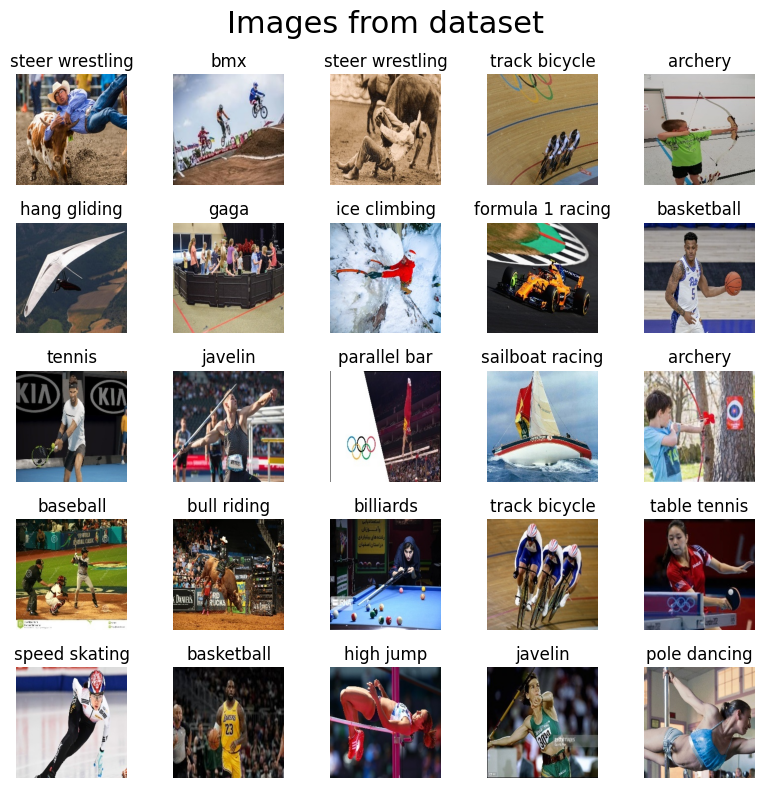

In [ ]:
fig , axes = plt.subplots(5,5,figsize=(8,8))
fig.suptitle("Images from dataset",fontsize = 22)


for i , ax in enumerate(axes.flat):
  img = plt.imread(train_paths[i])
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"{train_labels[i]}")

plt.tight_layout()
plt.show()


# Applying transformation (data Augmentation)

In [ ]:
class TransformationAndAugmentation:
  def __init__(self):
    self.transformation1 = transforms.Compose([  # transforming image according to the VGG16 model
        transforms.Resize(224),
        transforms.CenterCrop(224),
    ])

    self.transformation2 = transforms.Compose([ # Data Augmentation
        transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomRotation(30, fill=(240, 240, 240)),  # filling white where rotation occured
        transforms.RandomAdjustSharpness(0.5),
        transforms.ColorJitter(                        # Random brightness/contrast/saturation/hue
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.05
            ),
            transforms.RandomAdjustSharpness(2, p=0.3),    # Occasionally sharpen
            transforms.RandomAutocontrast(p=0.2),          # Random auto-contrast
            transforms.RandomPerspective(distortion_scale=0.2, p=0.2, fill=(240, 240, 240)),

    ])

    self.transformation3 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5]*3 , std=[0.5]*3) # according to the VGG16 model
    ])

  def __call__(self , img):
    img = self.transformation1(img)
    img = self.transformation2(img)
    img = self.transformation3(img)

    return img

In [ ]:
# Transformation on Test dataset , according to VGG16 model

transformation_on_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.5]*3 , std = [0.5]*3)
])

### images before transformation

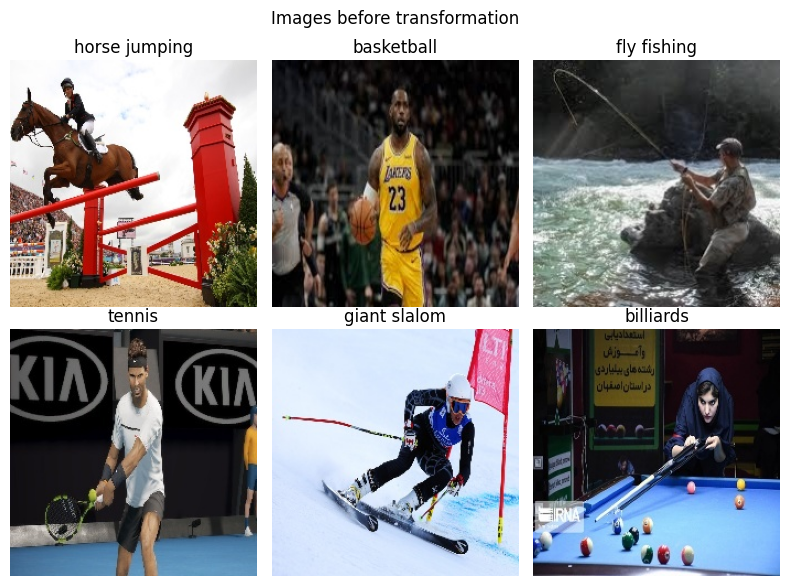

In [ ]:

import random

# Random indices
random.seed(34)
rand_indices = [random.randint(10, 40) for _ in range(6)]

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
fig.suptitle('Images before transformation')

for idx, ax in zip(rand_indices, axes.flat):
    img = plt.imread(train_paths[idx])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{train_labels[idx]}')

plt.tight_layout()
plt.show()


### Visualizing images after transformation
### Normaliaton was commented for this

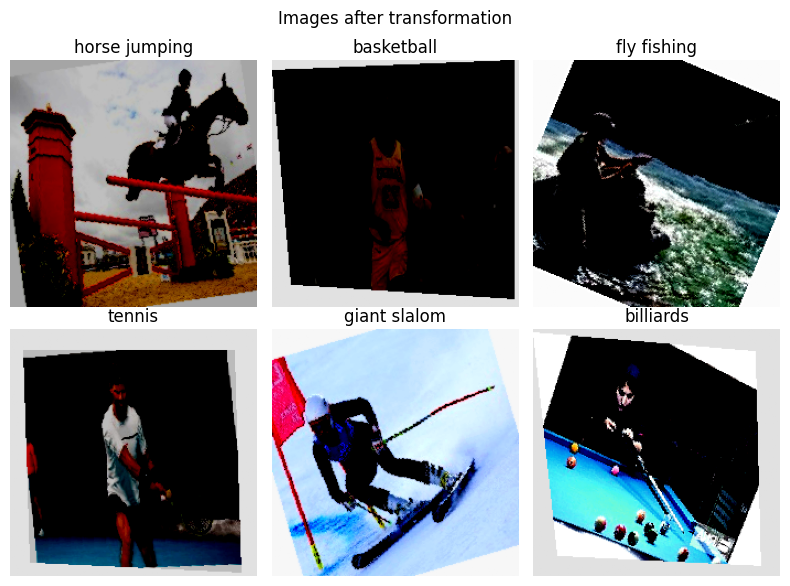

In [ ]:


# Apply and display
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
fig.suptitle("Images after transformation")

transformer = TransformationAndAugmentation()

for idx, ax in zip(rand_indices, axes.flat):
    img = Image.open(train_paths[idx]).convert("RGB")  # Read image correctly
    img_tensor = transformer(img)  # Apply transformations (result is tensor)

    # Convert tensor -> numpy for display
    img_np = img_tensor.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(train_labels[idx])

plt.tight_layout()
plt.show()


In [ ]:
# Coverting labels into integers

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

train_labels=le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

In [ ]:
le.classes_

array(['air hockey', 'ampute football', 'archery', 'arm wrestling',
       'axe throwing', 'balance beam', 'barell racing', 'baseball',
       'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx',
       'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping',
       'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket',
       'croquet', 'curling', 'disc golf', 'fencing', 'field hockey',
       'figure skating men', 'figure skating pairs',
       'figure skating women', 'fly fishing', 'football',
       'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf',
       'hammer throw', 'hang gliding', 'harness racing', 'high jump',
       'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching',
       'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting',
       'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse',
       'log rolling', 'luge', 'motorcycle racing', 'mushing',
       'nascar racing', 'olympic wrestling', 'parallel bar',
 

In [ ]:
print(len(set(train_labels)))
print(len(set(test_labels)))

100
100


### Making dataLoader and testLoader

In [ ]:
from PIL import Image, UnidentifiedImageError

class CustomDataset(Dataset):
  def __init__(self,images , labels,transformation = None):
    assert len(images) == len(labels), "Mismatch: images and labels must have same length"
    self.image_path = images
    self.labels = labels
    self.transformation = transformation

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self , idx):
    img_path = self.image_path[idx]
    label = torch.tensor(self.labels[idx] , dtype = torch.long)

    try:
        img = Image.open(img_path).convert("RGB")
    except UnidentifiedImageError:
        print(f"Skipping non-image file: {img_path}")
        # Return None or handle as appropriate for  DataLoader
        # Returning None will require a custom collate_fn in the DataLoader
        # For simplicity here, we'll just skip and potentially cause a batch size mismatch
        # or could return a placeholder, but skipping and handling in DataLoader is better.
        # Let's return a dummy tensor and label, which will be handled by filtering later
        return torch.zeros(3, 224, 224), -1 # Returning a dummy tensor and an invalid label

    if self.transformation:
        img = self.transformation(img)  # applying tranformation on images

    return img , label

In [ ]:
train_dataset = CustomDataset(train_paths, train_labels, TransformationAndAugmentation())
test_dataset = CustomDataset(test_paths, test_labels, TransformationAndAugmentation())


train_loader = DataLoader(train_dataset , batch_size=64 , shuffle=True , pin_memory=True)
test_loader = DataLoader(test_dataset , batch_size=64 , shuffle=True , pin_memory=True)

In [ ]:
# Loading VGG16 model

from torchvision.models import vgg16

model = vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# freezing all the layers of vgg16
for param in model.parameters():
  param.requires_grad=False

# Unfreezing last 3 Convolutional layer in the featuer extractor
# Unfreeze last 3 Conv2d layers only
conv_layers = [m for m in model.features if isinstance(m, nn.Conv2d)]
for layer in conv_layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

# unfreezing the classfier too
for param in model.classifier.parameters():
    param.requires_grad = True




In [ ]:
# Custom classifier architecture

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),

    nn.Linear(4096, 3000),
    nn.BatchNorm1d(3000),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),

    nn.Linear(3000, 614),
    nn.BatchNorm1d(614),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),

    nn.Linear(614, 100)  # final output layer for 100 classes
)


In [ ]:
# putting model on GPU
model = model.to(device)

In [ ]:
# Initializing parameter , loss function , optimizer

epochs=20
learning_rate=0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

## Training

In [ ]:


loss_history = []
accuracy_history = []

torch.cuda.empty_cache()

print(".......... TRAINING STARTED ...........")

for epoch in range(epochs):
    total_batch_loss = 0.0
    correct_prediction = 0
    total_samples = 0
    counter = 0

    loop = tqdm.tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', total=len(train_loader))

    for batch_image, batch_label in loop:
        # Ensure both data and model are on the same device
        batch_image = batch_image.to(device)
        batch_label = batch_label.to(device)

        # Forward pass
        output = model(batch_image)

        # Loss calculation
        loss = loss_fn(output, batch_label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        _, predicted = torch.max(output, dim=1)
        total_batch_loss += loss.item()
        total_samples += batch_label.size(0)
        correct_prediction += (predicted == batch_label).sum().item()

        # Clear GPU cache occasionally
        counter += 1
        if counter % 5 == 0:
            torch.cuda.empty_cache()

    avg_loss = total_batch_loss / len(train_loader)
    acc = 100 * (correct_prediction / total_samples)

    loss_history.append(avg_loss)
    accuracy_history.append(acc)

    print(f"EPOCH {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")
    torch.cuda.empty_cache()

.......... TRAINING STARTED ...........


Epoch 1/20: 100%|██████████| 211/211 [04:05<00:00,  1.16s/it]


EPOCH 1 | Loss: 2.7868 | Accuracy: 29.64%


Epoch 2/20: 100%|██████████| 211/211 [04:06<00:00,  1.17s/it]


EPOCH 2 | Loss: 1.6032 | Accuracy: 54.88%


Epoch 3/20: 100%|██████████| 211/211 [04:06<00:00,  1.17s/it]


EPOCH 3 | Loss: 1.2629 | Accuracy: 63.07%


Epoch 4/20: 100%|██████████| 211/211 [04:03<00:00,  1.15s/it]


EPOCH 4 | Loss: 1.0629 | Accuracy: 68.49%


Epoch 5/20: 100%|██████████| 211/211 [03:43<00:00,  1.06s/it]


EPOCH 5 | Loss: 0.8983 | Accuracy: 73.85%


Epoch 6/20: 100%|██████████| 211/211 [03:39<00:00,  1.04s/it]


EPOCH 6 | Loss: 0.7998 | Accuracy: 75.57%


Epoch 7/20: 100%|██████████| 211/211 [03:39<00:00,  1.04s/it]


EPOCH 7 | Loss: 0.7097 | Accuracy: 78.41%


Epoch 8/20: 100%|██████████| 211/211 [03:41<00:00,  1.05s/it]


EPOCH 8 | Loss: 0.6335 | Accuracy: 81.49%


Epoch 9/20: 100%|██████████| 211/211 [03:41<00:00,  1.05s/it]


EPOCH 9 | Loss: 0.5819 | Accuracy: 82.66%


Epoch 10/20: 100%|██████████| 211/211 [03:34<00:00,  1.02s/it]


EPOCH 10 | Loss: 0.5309 | Accuracy: 83.66%


Epoch 11/20: 100%|██████████| 211/211 [03:37<00:00,  1.03s/it]


EPOCH 11 | Loss: 0.4992 | Accuracy: 84.89%


Epoch 12/20: 100%|██████████| 211/211 [03:35<00:00,  1.02s/it]


EPOCH 12 | Loss: 0.4210 | Accuracy: 87.04%


Epoch 13/20: 100%|██████████| 211/211 [03:35<00:00,  1.02s/it]


EPOCH 13 | Loss: 0.4108 | Accuracy: 87.48%


Epoch 14/20: 100%|██████████| 211/211 [03:34<00:00,  1.02s/it]


EPOCH 14 | Loss: 0.3860 | Accuracy: 87.91%


Epoch 15/20: 100%|██████████| 211/211 [03:33<00:00,  1.01s/it]


EPOCH 15 | Loss: 0.3550 | Accuracy: 88.78%


Epoch 16/20: 100%|██████████| 211/211 [03:36<00:00,  1.03s/it]


EPOCH 16 | Loss: 0.3361 | Accuracy: 89.43%


Epoch 17/20: 100%|██████████| 211/211 [03:38<00:00,  1.04s/it]


EPOCH 17 | Loss: 0.3040 | Accuracy: 90.71%


Epoch 18/20: 100%|██████████| 211/211 [03:38<00:00,  1.03s/it]


EPOCH 18 | Loss: 0.3070 | Accuracy: 89.85%


Epoch 19/20: 100%|██████████| 211/211 [03:38<00:00,  1.04s/it]


EPOCH 19 | Loss: 0.2875 | Accuracy: 90.97%


Epoch 20/20: 100%|██████████| 211/211 [03:38<00:00,  1.04s/it]

EPOCH 20 | Loss: 0.2817 | Accuracy: 91.31%


# Evaluation

In [ ]:
model.eval()
print("............. Evaluating the model .............")

all_preds = []
all_true_label = []
correct_prediction = 0  # ✅ must initialize

with torch.no_grad():
    for batch_image, batch_label in test_loader:
        batch_image = batch_image.to(device)
        batch_label = batch_label.to(device)

        output = model(batch_image)
        _, prediction = torch.max(output, dim=1)

        correct_prediction += (prediction == batch_label).sum().item()

        # Collect predictions and labels as flat NumPy arrays
        all_preds.extend(prediction.cpu().numpy())
        all_true_label.extend(batch_label.cpu().numpy())


# calculating total accuracy
accuracy = 100 * (correct_prediction / len(test_dataset))

print(f"Accuracy on test data is : {accuracy:.2f}%")


............. Evaluating the model .............
Accuracy on test data is : 89.80%


## LOSS AND ACCURACY GRAPH

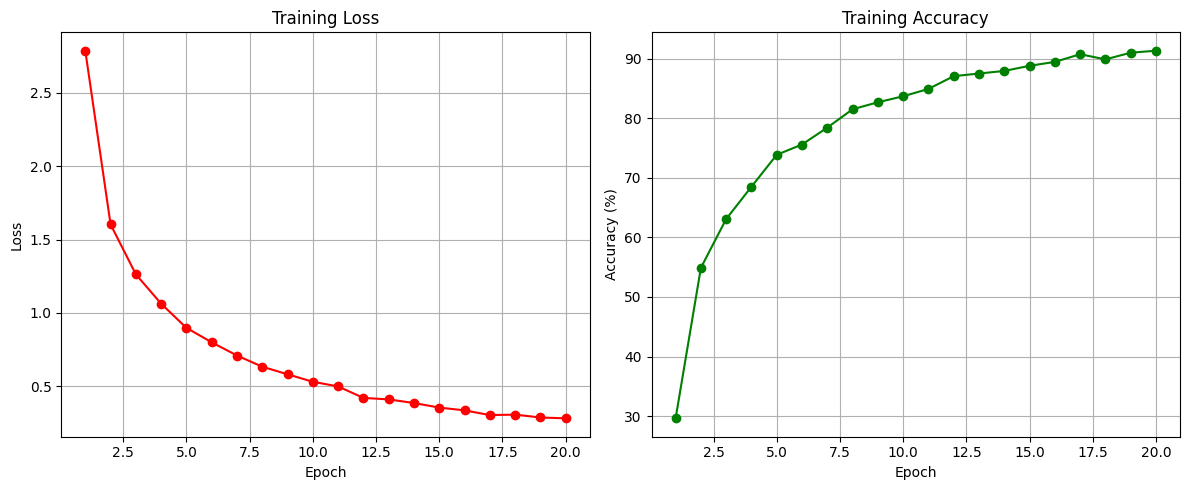

In [ ]:


epochs_range = range(1, len(loss_history) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_history, marker='o', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy_history, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()


### **Heatmap**

### Classification report

In [ ]:
from sklearn.metrics import classification_report

print("Classification report :")
print(classification_report(all_true_label , all_preds , target_names=le.classes_))


Classification report :
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      0.80      0.89         5
              archery       0.83      1.00      0.91         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      0.80      0.89         5
         balance beam       1.00      0.80      0.89         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.71      1.00      0.83         5
           basketball       0.83      1.00      0.91         5
       baton twirling       0.80      0.80      0.80         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       0.75      0.60      0.67         5
              bowling       1.

# prediction

In [ ]:


def predict_sport_from_path(image_path, transform, label_encoder,):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img = transform(img)  # Apply the same transforms used in training
    img = img.unsqueeze(0)  # Add batch dimension [1, C, H, W]
    img = img.to(device)

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        predicted_class_idx = predicted.item()

    # Convert class index to label using LabelEncoder
    predicted_label = label_encoder.inverse_transform([predicted_class_idx])[0]
    return predicted_label


In [ ]:
transformation55 =  TransformationAndAugmentation()

example_image_path =  '/content/bull_riding.jpg'

print( predict_sport_from_path(example_image_path , transformation55 ,le))

bull riding


In [ ]:
# saving model

torch.save(model.state_dict(), "sports_classifier.pth")
import joblib
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [ ]:
from google.colab import files

files.download("sports_classifier.pth")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/sports_claassifier.pth")
